# Title 
## Enhancing Intruct based Question Answering with LLM Fine-Tuning: A Deep Dive into the QLora Layer and Optimized Training

# Introduction

Natural Language Processing (NLP) has witnessed revolutionary advancements in recent years, largely driven by the emergence of Large Language Models (LLMs). These models, such as Flan T5 Large, have shown impressive results across various NLP tasks, including question answering. In this article, we explore a project that focuses on fine-tuning the Flan T5 Large model for question-answering tasks using the Open Orca dataset. The project employs the Hugging Face library and a specially designed QLora layer, optimizing the fine-tuning setup to achieve enhanced language understanding and response generation.

## Flan T5 Model

The Flan T5 model is a variant of the T5 (Text-to-Text Transfer Transformer) model, an architecture developed by Google. It is based on the Transformer model and is designed for a wide range of natural language processing tasks.

## T5
T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

**Technical Details:**

1. **Architecture:** Flan T5 follows the same basic architecture as the original T5 model, consisting of an encoder-decoder transformer with a shared vocabulary between the two. However, it may incorporate modifications to enhance its performance on specific tasks.

2. **Task Agnostic:** Flan T5, like T5, is a "text-to-text" model, treating all NLP tasks as text-to-text problems. It uses a unified framework for various tasks by converting them into a text-to-text format, where both input and output are represented as textual sequences.

3. **Pre-training:** The Flan T5 model undergoes unsupervised pre-training on large-scale datasets to learn language representations effectively. This pre-training is a crucial step for achieving good performance on downstream tasks.

4. **Fine-tuning:** After pre-training, the Flan T5 model is fine-tuned on specific downstream tasks with labeled data. This process adapts the model to perform well on a wide range of NLP tasks, such as text classification, language translation, and question-answering.

**Differences from T5:**

The main difference between Flan T5 and the original T5 model lies in the modifications made to enhance its performance on particular tasks. These modifications could include changes to the architecture, different pre-training datasets, or fine-tuning techniques aimed at improving task-specific capabilities.

In the comparison involving three setups: direct fine-tuning of T5 on the target task, using Flan-T5 without additional fine-tuning on the target task, and fine-tuning Flan-T5 on the target task. Fine-tuning Flan-T5 shows better performance than direct fine-tuning of T5 for both held-in and held-out tasks. In cases with limited training data for the target task, Flan-T5 without further fine-tuning often outperforms T5 with direct fine-tuning.

Reference:

https://huggingface.co/docs/transformers/model_doc/flan-t5

https://ai.googleblog.com/2023/02/the-flan-collection-advancing-open.html

# Environment Setup

In [1]:
import sys

if 'kaggle_web_client' in sys.modules:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    HUGGINGFACE_API_KEY = user_secrets.get_secret("SHIRSH_HUGGINGFACE_API_KEY")
    # WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()
    HUGGINGFACE_API_KEY = os.getenv('SKT_HUGGINGFACE_API_KEY')
    # WANDB_API_KEY = os.getenv("WANDB_API_KEY")

# Installing and Loading Libraries

In [2]:
!pip install -q accelerate 
!pip install -q datasets loralib einops
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

In [3]:
from datasets import load_dataset, Dataset
import torch
from torch.optim import AdamW
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import bitsandbytes as bnb
from transformers import AutoTokenizer, get_scheduler, BitsAndBytesConfig, GenerationConfig, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from peft import PeftModel, PeftConfig, prepare_model_for_kbit_training, LoraConfig, get_peft_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# API login

In [4]:
# import wandb
# !wandb login WANDB_API_KEY

In [5]:
from huggingface_hub import notebook_login
from huggingface_hub import login
login(token=HUGGINGFACE_API_KEY, write_permission=True)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Configurations

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# commit_log = "Fine tuning on first 10k dataset for 5 epochs, made the model's head as Trainable"
commit_log = "full_run_epoch3_data75k_batch16"
model_save = True
num_epochs = 1
BATCH_SIZE = 16 
n_samples = 75000
checkpoint = "google/flan-t5-large"
initial_learning_rate = 8e-5
peft_combine = True    # turn it false for the first epoch only
patience = 750
decay_factor = 0.8

# lora_config is effective only when peft_combine = False
lora_config = LoraConfig( r=8, lora_alpha=16, target_modules=['q', 'v'], lora_dropout=0.05, bias="none", task_type= "SEQ_2_SEQ_LM" )#,modules_to_save=["lm_head"])

# Load Dataset | Open Orca

##### The Open Orca dataset, carefully curated for question answering tasks, provides an ideal testbed for our fine-tuning project. It comprises diverse questions and corresponding answers, spanning various topics and complexities. The task involves training the Flan T5 Large model to predict the correct answers for the given questions, thus necessitating a deep understanding of both the queries and the context.

The OpenOrca dataset is a collection of augmented FLAN Collection data used in natural language processing. It contains around 1 million completions from GPT-4 and 3.2 million completions from GPT-3.5. 

The data is organized in a tabular format following the distributions presented in the ORCA paper. This dataset represents a partial completion of the intended dataset, with ongoing generation to expand its scope. 

Each data instance consists of entries from the FLAN Collection that have been augmented by submitting a question to either GPT-4 or GPT-3.5, and the corresponding response is recorded in the response field. 

### Data fields:

- **id**: A unique numbered identifier that includes one of 'niv', 't0', 'cot', or 'flan' to represent which source FLAN Collection submix the 'question' is sourced from.
- **system_prompt**: Represents the System Prompt presented to the GPT-3.5 or GPT-4 API for the datapoint.
- **question**: Represents a question entry as provided by the FLAN Collection.
- **response**: A response to that question received from a query to either GPT-3.5 or GPT-4.


### Data Preprocessing:

1. The Flan T5 model has a token limitation of 512 tokens. To ensure compliance, the token length of each row was calculated, and it was found that some instances had token lengths (prompt + question) exceeding the limit, reaching approximately 80,000 tokens. To address this, the prompts of these instances were manually shortened.

2. The data was tokenized by combining the input (prompt + " " + question) and labels (response). This process converts the text into numerical representations that can be fed into the Flan T5 model for training and evaluation.

In [7]:
# dataset = load_dataset("SKT27182/Preprocessed_OpenOrca", streaming=True)
dataset = load_dataset("shirsh10mall/LLM_Instruct_Learning_Project_Preprocessed_Tokenized_Open_Orca_Dataset_Flan_T5", streaming=True)

data = { "input_ids":[], "attention_mask":[], "labels": [], "system_prompt":[], "question":[], "response":[]}

for i, sample in enumerate(dataset["train"]):
    if i >= n_samples:
        break
    for key, value in sample.items():
        if key in data.keys():
            data[key].append(value)
        
open_orca = Dataset.from_dict(data)

## Instruct Fine-Tuning in LLMs:
Instruct Fine-Tuning is a technique used in Language Model Pretraining (LLM) to adapt pre-trained models for specific tasks. It involves providing explicit task instructions along with input examples during the fine-tuning process. By incorporating task-specific instructions, the model can better understand and perform the desired task, leading to improved performance on downstream tasks.

**Instruction Question Answer Example:**
Suppose we have a pre-trained language model, and we want to fine-tune it for question-answering on a specific dataset containing questions and corresponding answers. During the instruct fine-tuning process, we provide the model with explicit instructions for the question-answering task, such as: "Given the input question, find the answer within the provided context."

Example input:
- Context: "In 1969, humans first landed on the moon."
- Question: "What year did humans land on the moon?"

Example instruction: "Answer the question within the provided context."

Based on these instructions, the model learns to process the context and question to generate the correct answer, such as "1969." By fine-tuning with such instructions, the model becomes more adept at handling question-answering tasks effectively.

# PEFT and LoRA
**Parameter Efficient Fine-tuning (PEFT) and Low-Rank Adaptation (LoRA) in LLMs**

**Introduction:**
Training large language models and fine-tuning them can be computationally expensive and lead to large model sizes, making deployment and storage challenging, especially on consumer hardware. As models grow larger, these issues become more pronounced. Parameter Efficient Fine-tuning (PEFT) addresses these challenges by only fine-tuning a small number of (extra) model parameters while freezing most parameters of the pretrained LLMs. This greatly decreases the computational and storage costs, making it more feasible to train on consumer hardware and deploy fine-tuned models across multiple downstream tasks.

**PEFT and LoRA:**
PEFT is a method that efficiently fine-tunes large language models by leveraging techniques like Low-Rank Adaptation (LoRA). LoRA focuses on adding a low-rank factorization to the pre-trained model's weight matrices. By doing so, LoRA introduces additional trainable weights while maintaining a smaller number of trainable parameters compared to full fine-tuning. This approach helps prevent catastrophic forgetting, a behavior observed during the full fine-tuning of LLMs, where the model forgets its pre-trained knowledge when fine-tuned on new tasks.

**Benefits of PEFT:**
1. **Efficiency:** PEFT enables fine-tuning with a small amount of data, making it particularly useful in low-data scenarios. It mitigates the need for extensive labeled data during fine-tuning.
2. **Generalization:** PEFT approaches have shown to generalize better to out-of-domain scenarios. The reduced catastrophic forgetting allows the model to retain its pre-trained knowledge while adapting to new tasks.
3. **Portability:** Fine-tuned models using PEFT have considerably smaller checkpoints compared to full fine-tuning. For instance, models like bigscience/mt0-xxl take up 40GB of storage with full fine-tuning, whereas using PEFT methods would lead to just a few MBs for each downstream dataset while achieving comparable performance. This portability facilitates the use of the same LLM for multiple tasks by adding small weights without having to replace the entire model.

**Hugging Face PEFT Library:**
Hugging Face has introduced a library that integrates PEFT with the transformers and accelerate libraries, providing an easy-to-use framework for implementing PEFT in various tasks. This integration allows users to efficiently fine-tune pre-trained models from different sources using PEFT techniques, making it accessible to a wider range of users in the natural language processing community. The Hugging Face PEFT library streamlines the process of fine-tuning and enables users to achieve performance comparable to full fine-tuning while only having a small number of trainable parameters.


**Steps in LoRA (Low-Rank Adaptation of LLMs):**

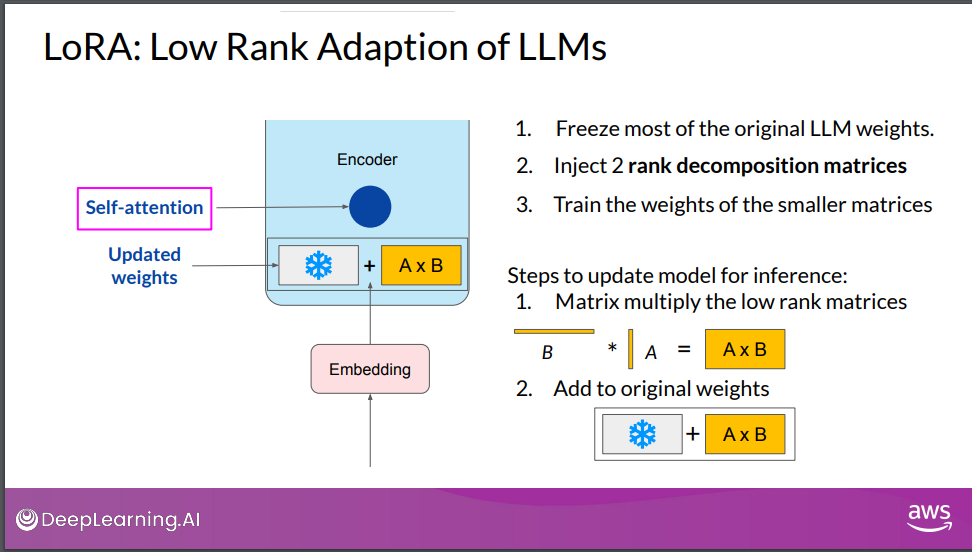

Reference: [coursera.org/learn/generative-ai-with-llms](http://)

1. **Freeze most of the original LLM weights:** During the fine-tuning process, the majority of the parameters in the pre-trained large language model (LLM) are kept frozen and unchanged. This ensures that the model retains its original knowledge and prevents catastrophic forgetting.

2. **Inject 2 rank decomposition matrices:** LoRA introduces two rank decomposition matrices to the frozen pre-trained LLM. These matrices serve as additional parameters and are responsible for capturing task-specific information during fine-tuning.

3. **Train the weights of the smaller matrices:** During fine-tuning, the parameters of the two rank decomposition matrices are trained on the target task data. This step allows the model to adapt to the specific task while minimizing the number of trainable parameters, leading to parameter-efficient fine-tuning.

**Steps to Update Model for Inference:**

1. **Matrix multiply the low-rank matrices:** During inference or deployment, the low-rank decomposition matrices are multiplied by the pre-trained LLM's frozen parameters. This operation reconstructs the fine-tuned model's weight matrices, incorporating the task-specific adaptations learned during training.

2. **Add to original weights:** The matrices obtained from the matrix multiplication are added to the original frozen LLM weights. This combination of the pre-trained knowledge and task-specific information enables the model to generate accurate and contextually relevant responses during inference, providing the best of both worlds: efficiency and task performance.

LoRA is an effective technique for parameter-efficient fine-tuning, allowing large language models to be adapted to new tasks with minimal additional trainable parameters while maintaining excellent performance. The rank decomposition approach reduces the computational and storage costs associated with full fine-tuning, making it more feasible to deploy fine-tuned models on resource-constrained devices and systems.

# Quantized Low-Rank Adaptation (QLoRA) in LLMs

To address diverse text generation needs and enable efficient fine-tuning of large language models (LLMs), Meta introduces QLoRA (Efficient Fine-tuning of Quantized LLMs). QLoRA is an innovative technique that involves quantizing a pre-trained LLM to just 4 bits and incorporating small "Low-Rank Adapters" for efficient fine-tuning. This approach reduces memory usage during fine-tuning without compromising performance compared to standard 16-bit model fine-tuning. 

**How QLoRA works:**
1. **4-bit Quantization:** QLoRA first compresses a pre-trained language model using 4-bit quantization. This reduces the number of bits used to represent numerical values, resulting in memory savings.

2. **Incorporating Low-Rank Adapters:** The parameters of the 4-bit quantized language model are frozen, and a relatively small number of trainable parameters, known as Low-Rank Adapters, are added to the model.

3. **Fine-tuning with Low-Rank Adapters:** During fine-tuning, QLoRA backpropagates gradients through the frozen 4-bit quantized pretrained language model into the Low-Rank Adapters. Only the Low-Rank Adapters' parameters are updated during training, minimizing the number of trainable parameters and computational costs.

4. **Memory-Efficient Computation:** QLoRA uses a 4-bit NormalFloat storage data type for the base model weights and a 16-bit BrainFloat computation data type for computations. Weight gradients for the Low-Rank Adapters are computed using 16-bit bfloat. The weights are dequantized only when needed, resulting in low memory usage during training and inference.

**Benefits of QLoRA:**
- QLoRA matches the performance of 16-bit fine-tuning methods while significantly reducing memory usage, allowing for efficient fine-tuning of large models.
- QLoRA enables 33B model fine-tuning on a single 24GB GPU and 65B model fine-tuning on a single 46GB GPU, making it practical for resource-constrained environments.
- QLoRA tuning has been applied to state-of-the-art chatbot systems like the Guanaco models, leading to competitive performance on the Vicuna benchmark.

Overall, QLoRA is a powerful technique that combines quantization and low-rank adaptation to make fine-tuning of LLMs more memory-efficient and scalable, without sacrificing performance.

# BitsAndBytes
The provided code snippet defines a configuration object called "bnb_config" for the "BitsAndBytes" (bnb) library. This configuration is designed to enable 4-bit quantization for a deep learning model, specifically using the "torch" library with a bfloat16 compute data type. Let's break down the code and its technical implications:

**Explanation of the Code:**

1. **BitsAndBytesConfig:** This line creates an instance of the BitsAndBytesConfig class, which is used to set up configurations for quantization in the BitsAndBytes library.

2. **load_in_4bit=True:** This parameter instructs the BitsAndBytes library to load the model in a 4-bit quantized format. In other words, the model will be loaded with weights represented using only 4 bits, significantly reducing memory usage compared to full-precision floating-point representation.

3. **bnb_4bit_use_double_quant=True:** This parameter enables double quantization for 4-bit weights. Double quantization refers to the process of quantizing a quantized model further, effectively reducing the number of bits used to represent the weights even more. This can lead to additional memory and computational efficiency.

4. **bnb_4bit_quant_type="nf4":** This parameter specifies the type of quantization method to be used. In this case, "nf4" indicates that the quantization is performed using normalfloat4, which is a common format for representing 4-bit values.

5. **bnb_4bit_compute_dtype=torch.bfloat16:** This parameter sets the compute data type to be used during computations in the quantized model.

In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_length

512

# Model Instantiation | QLora
The provided code snippet instantiates a language model, either a T5 large model with PEFT (Parameter Efficient Fine-tuning) or a model with Low-Rank Adaptation (LoRA) using Quantized Low-Rank Adaptation (QLoRA) technique, depending on the value of the "peft_combine" flag.

**Explanation of the Code:**

1. **Instantiate the T5 large model:** The code starts by initializing the T5 large language model, which will be used as the base model for fine-tuning.

2. **if peft_combine:** This condition checks whether to use PEFT or LoRA-based QLoRA approach for fine-tuning. If "peft_combine" is True, it indicates that the PEFT approach will be used.

3. **PEFT Approach:**
   1. **peft_model_id:** The ID of the PEFT model, which is used to identify the pre-trained model to be fine-tuned.
   2. **PeftConfig:** The configuration class used to set up the PEFT fine-tuning.
   3. **AutoModelForSeq2SeqLM:** The Hugging Face library's class to instantiate a sequence-to-sequence language model.
   4. **load_in_8bit=True:** This parameter specifies to load the model in an 8-bit quantized format. The model will be quantized using 8-bit fixed-point representation, reducing memory usage while maintaining reasonable precision.
   5. **device_map={"":0}:** The device map specifies which device (GPU) to use for model training. In this case, device 0 is used.
   6. **trust_remote_code=True:** This parameter indicates that it's safe to trust the remote code from the model provider.
   7. **AutoTokenizer:** The Hugging Face library's class to instantiate a tokenizer for the model.

4. **LoRA-based QLoRA Approach:**
   1. **AutoModelForSeq2SeqLM:** The code initializes the language model using the T5 checkpoint.
   2. **quantization_config=bnb_config:** The parameter "quantization_config" is used to specify the configuration for QLoRA-based fine-tuning. "bnb_config" is the configuration object for the BitsAndBytes (bnb) library, which contains settings for quantization.
   3. **model.gradient_checkpointing_enable():** This enables gradient checkpointing, which reduces memory consumption during model training by trading computation for memory. It helps train larger models that would otherwise exceed the memory capacity of the GPU.
   4. **prepare_model_for_kbit_training(model):** This function prepares the model for fine-tuning with QLoRA. It adds the necessary components and settings to make the model ready for efficient fine-tuning using QLoRA.
   5. **get_peft_model(model, lora_config):** This function performs Low-Rank Adaptation (LoRA) on the model, applying QLoRA-based fine-tuning to make the model parameter-efficient.

In [10]:
# if peft_combine:
#     peft_model_id = "shirsh10mall/First_LLM_Project"
#     # peft_model_id = "SKT27182/Qlora"

#     config = PeftConfig.from_pretrained(peft_model_id)
#     model = AutoModelForSeq2SeqLM.from_pretrained( config.base_model_name_or_path, return_dict=True, load_in_8bit=True, 
#                                                      device_map={"":0}, trust_remote_code=True, )

#     tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

#     # Load the Lora model
#     model = PeftModel.from_pretrained(model, peft_model_id) #, is_trainable=True)
# else:
#     model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)

#     model.gradient_checkpointing_enable()

#     model = prepare_model_for_kbit_training(model)

#     model = get_peft_model(model, lora_config)

In [11]:
# # Function to compare model layers
# def compare_models(model1, model2):
#     for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
#         print(param1.shape, param2.shape)
#         print(name1 , "  |  " , name2 , "\n \n")
#         if not torch.equal(param1, param2):
#             print(f"Weights are not the same in layer: {name1}")
#             return False
#     return True

In [12]:
import copy

if peft_combine:
    peft_model_id = "shirsh10mall/First_LLM_Project"
    # peft_model_id = "SKT27182/Qlora"
    config = PeftConfig.from_pretrained(peft_model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained( config.base_model_name_or_path, return_dict=True, quantization_config=bnb_config,
                                                     device_map={"":0}, trust_remote_code=True, )
    
    model = prepare_model_for_kbit_training(model)

    tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

    # Load the Lora model
    model = PeftModel.from_pretrained(model, peft_model_id, is_trainable=True)
    
    original_head = copy.deepcopy(model.lm_head.state_dict())
#     print(original_head)
    
    # adding the fine-tuned head
    lm_head_state_dict = torch.load("/kaggle/input/qlora-llm-instruct-fine-tuning-flan-t5-large/my_model/LLM_Fine_Tuned_Model_NumExample_75000_Epoch_1.pt")
    model.lm_head.load_state_dict(lm_head_state_dict)
        
else:
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    # model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    

try:
    !mkdir /kaggle/working/my_model
except:
    print("Directory Exists")

In [13]:
model.lm_head.state_dict()

OrderedDict([('weight',
              tensor([[ 0.1640,  0.3911,  0.3386,  ..., -0.6558,  1.2949, -0.0613],
                      [-0.1024,  0.0737,  0.6093,  ...,  0.0532,  0.2807, -0.1408],
                      [-0.2247, -0.4466, -0.0228,  ..., -0.0037,  0.3009,  0.2086],
                      ...,
                      [ 0.1383,  0.4691,  0.3127,  ..., -0.6607,  1.2610, -0.0443],
                      [ 0.1187,  0.4408,  0.3092,  ..., -0.6528,  1.2578, -0.0525],
                      [ 0.1615,  0.4717,  0.3078,  ..., -0.6650,  1.2503, -0.0214]],
                     device='cuda:0'))])

In [14]:
original_head

OrderedDict([('weight',
              tensor([[ 0.1582,  0.3970,  0.3408,  ..., -0.7036,  1.3828, -0.0663],
                      [-0.0837,  0.0909,  0.5737,  ...,  0.0438,  0.2507, -0.0967],
                      [-0.2134, -0.5503, -0.0191,  ...,  0.0437,  0.2415,  0.1221],
                      ...,
                      [ 0.1335,  0.4812,  0.3162,  ..., -0.7065,  1.3447, -0.0477],
                      [ 0.1126,  0.4512,  0.3120,  ..., -0.6987,  1.3418, -0.0564],
                      [ 0.1567,  0.4829,  0.3101,  ..., -0.7119,  1.3340, -0.0240]],
                     device='cuda:0'))])

In [15]:
def check_lm_head_same(model, old_head):
    new_head = model.lm_head.state_dict()["weight"]
    old_head = old_head["weight"]
    if not torch.equal(new_head, old_head):
        print("Weights are different")
    else:
        print("Weights are same. Try to add the correct lm_head")
        
if peft_combine:
    check_lm_head_same(model, original_head)

Weights are different


In [16]:
# def get_base_and_lora_model(peft_model, full_model_config):
#     torch.cuda.empty_cache()
#     full_model_config = peft_model.model.config
    
#     base_model = AutoModelForSeq2SeqLM.from_config(full_model_config).to(device)
#     base_model_dict = base_model.state_dict()
    
#     for name, param in peft_model.model.named_parameters():
        
#         # skip the lora layers
#         if "lora_A" in name or "lora_B" in name:
#             continue
#         name = ".".join(name.split(".")[1:])
#         base_model_dict[name] = param
        
#     base_model.load_state_dict(base_model_dict)
    
#     return base_model

# torch.cuda.empty_cache()
# # out_config
# trr = get_base_and_lora_model(model, base_model_2.config)

In [17]:
# # Function to compare model layers
# def compare_models(model1, model2):
#     for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
#         if "lora_A" in name1 or "lora_B" in name1:
#             continue
#         print(param1.shape, param2.shape)
#         print(name1 , "  |  " , name2 , "\n \n")
#         if not torch.equal(param1, param2):
#             print(f"Weights are not the same in layer: {name1}")
#             print(param1[:5], param2[:5])
#             return False
#     return True

# compare_models(model.model, trr)

# Dataloader Setup

1. `tokenized_open_orca_data = open_orca.remove_columns(["system_prompt", "question", "response"])`: The code removes unnecessary columns ("system_prompt", "question", and "response") from the pre-tokenized dataset, preparing it for training with an encoder-decoder-based model.

2. `tokenized_open_orca_data.set_format("torch")`: The data format of the tokenized dataset is set to "torch" to ensure compatibility with the PyTorch framework, which will be used for training.

3. `print(tokenized_open_orca_data.column_names)`: This line prints the names of the columns present in the tokenized dataset, verifying the remaining columns after removing the specified ones.

4. `data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True, label_pad_token_id=-100, return_tensors="pt")`: A data collator is created for the Seq2Seq model, which combines and prepares the tokenized data for batch processing during training. The "padding" parameter is set to True, and the label padding token ID is set to -100.

5. `from torch.utils.data import DataLoader`: The DataLoader class from the PyTorch library is imported to create data loaders for efficient handling of the training data.

6. `train_dataloader = DataLoader(tokenized_open_orca_data, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator, pin_memory=True, prefetch_factor=4, num_workers=2)`: A training data loader is created using the DataLoader class, which will handle the tokenized data during training. The data is shuffled, and "BATCH_SIZE" indicates the number of samples in each batch. The "collate_fn" argument is set to the previously defined data collator for Seq2Seq. "pin_memory" and "prefetch_factor" are set to optimize memory usage, and "num_workers" specifies the number of CPU workers to load data in parallel.

In summary, this code prepares a tokenized dataset for training an encoder-decoder-based model using PyTorch. The unnecessary columns are removed, and the data is formatted to torch tensors. A data collator is created to process the data during batch training, and a DataLoader is set up to efficiently load and handle the training data during model training.

In [18]:
open_orca

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'system_prompt', 'question', 'response'],
    num_rows: 75000
})

In [19]:
# For encoder-decoder based model (AutoModelForSeq2SeqLM)  for pre_tokenized dataset
tokenized_open_orca_data = open_orca.remove_columns(["system_prompt", "question", "response"])

# setting to format to torch as using torch for training
tokenized_open_orca_data.set_format("torch")

# printing the columns which are present in the tokenized dataset
print(tokenized_open_orca_data.column_names)

# creating dataloader not for Trainer
from torch.utils.data import DataLoader
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True, label_pad_token_id=-100, return_tensors="pt")

# train dataloader
train_dataloader = DataLoader( tokenized_open_orca_data, shuffle=True, batch_size=BATCH_SIZE , collate_fn=data_collator , pin_memory=True, prefetch_factor=4 , num_workers=2)

['input_ids', 'attention_mask', 'labels']


In [20]:
# # For encoder-decoder based model (AutoModelForSeq2SeqLM)

# # function to tokenize the input and response
# def input_tokenizer(examples):
    
#     prompts = examples['system_prompt']
#     questions = examples['question']
#     responses = examples['response']
    
#     inputs = [prompt + " " + question for prompt, question in zip(prompts, questions)]
    
#     model_inputs = tokenizer(inputs, padding=False, truncation=True)
    
#     labels = tokenizer(responses, padding=False, truncation=True).input_ids
    
#     model_inputs["labels"] = labels
    
#     return model_inputs
    

# # maping the above function to tokenize the dataset, removed the unnecessary features
# tokenized_open_orca_data = open_orca.map(input_tokenizer, batched=True, load_from_cache_file=False, remove_columns= open_orca["train"].column_names)


# # setting to format to torch as using torch for training
# tokenized_open_orca_data.set_format("torch")

# # printing the columns which are present in the tokenized dataset
# print(tokenized_open_orca_data.column_names)

# # creating dataloader not for Trainer
# from torch.utils.data import DataLoader
# data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True,label_pad_token_id=-100,return_tensors="pt")

# BATCH_SIZE = 16

# # train dataloader
# train_dataloader = DataLoader( tokenized_open_orca_data["train"], shuffle=True, batch_size=BATCH_SIZE , collate_fn=data_collator )

# # test dataloader
# validation_dataloader = DataLoader( tokenized_open_orca_data["test"], batch_size=1 , collate_fn=data_collator ) # BATCH_SIZE//4

In [21]:
# # For autoregressive transformer decoder (AutoModelForCausalLM)
# tokenizer.pad_token = tokenizer.eos_token

# def input_tokenizer(examples):
    
#     prompts = examples['system_prompt']
#     questions = examples['question']
#     responses = examples['response']
    
    
#     input_prompt =  prompts +"\n###Question: " + questions +"\n###Response: " + responses

#     model_inputs = tokenizer(input_prompt, padding=True, truncation=True)
    
#     model_inputs["decoder_input_ids"] = model_inputs["input_ids"]
    

#     return model_inputs

# # maping the above function to tokenize the dataset, removed the unnecessary features
# tokenized_open_orca_data = open_orca.map(input_tokenizer, load_from_cache_file=False, remove_columns= open_orca["train"].column_names)



# # tokenized_open_orca_data = tokenized_open_orca_data.rename_column('input_ids', 'decoder_input_ids')
# # tokenized_open_orca_data = tokenized_open_orca_data.rename_column('token_type_ids', 'decoder_attention_mask')
# # tokenized_open_orca_data = tokenized_open_orca_data.rename_column( 'attention_mask', 'decoder_inputs_embeds')


# # setting to format to torch as using torch for training
# tokenized_open_orca_data.set_format("torch")

# # printing the columns which are present in the tokenized dataset
# print(tokenized_open_orca_data.column_names)


# # creating dataloader not for Trainer
# from torch.utils.data import DataLoader
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# BATCH_SIZE = 4

# # train dataloader
# train_dataloader = DataLoader(
#     tokenized_open_orca_data["train"], shuffle=True, batch_size=BATCH_SIZE , collate_fn=data_collator
# )

# # test dataloader
# validation_dataloader = DataLoader(
#     tokenized_open_orca_data["test"], batch_size=BATCH_SIZE , collate_fn=data_collator
# )

## Set Model Head as Trainable

1. `print(model.base_model.model.lm_head.weight.requires_grad)`: This line prints the current value of the "requires_grad" attribute for the weights of the language model's head. "requires_grad" is a flag that determines whether the weights are trainable during model optimization.

2. `model.base_model.model.lm_head.weight.requires_grad = True`: This line sets the "requires_grad" attribute of the language model's head weights to True, making the weights trainable.

3. `print(model.base_model.model.lm_head.weight.requires_grad)`: This line prints the updated value of the "requires_grad" attribute after making the language model's head weights trainable.

**Technical Explanation:**

1. The code first checks if the language model's head weights are trainable by printing the current value of the "requires_grad" attribute. If the output is "False," it means the weights are not currently trainable.

2. The code then sets the "requires_grad" attribute of the language model's head weights to True using the assignment operation. This makes the weights trainable, and they will be updated during the model's optimization process.

3. Finally, the code prints the updated value of the "requires_grad" attribute to confirm that the language model's head weights are now trainable (output should be "True"). By setting the "requires_grad" attribute to True, the model's head parameters will be updated during backpropagation and gradient descent during training, enabling the model to learn and adapt to the specific task being fine-tuned.

In [22]:
print(model.base_model.model.lm_head.weight.requires_grad)
model.base_model.model.lm_head.weight.requires_grad = True
print(model.base_model.model.lm_head.weight.requires_grad)

False
True


The code calculates and prints the number of trainable parameters, the total number of parameters, and the percentage of trainable parameters in the given model. In the provided example, there are 35,258,368 trainable parameters out of a total of 496,102,400 parameters, representing 7.11% of the total parameters.

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print( f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}" )


print_trainable_parameters(model)

trainable params: 35258368 || all params: 496102400 || trainable%: 7.107074668455545


The code verifies the data types used in the model's parameters and calculates the percentage of parameters for each data type. The output shows that approximately 41.66% of the model's parameters are of type `torch.float32`, and about 58.34% of the parameters are of type `torch.uint8`.

In [24]:
# Verifying the datatypes.
dtypes = {}
for _, p in model.named_parameters():
    dtype = p.dtype
    if dtype not in dtypes:
        dtypes[dtype] = 0
    dtypes[dtype] += p.numel()
total = 0
for k, v in dtypes.items():
    total += v
for k, v in dtypes.items():
    print(k, v, v / total)

torch.float32 206695424 0.4166386294442438
torch.uint8 289406976 0.5833613705557562


# Fine Tuning

## Trainer Style 

In [25]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     per_device_train_batch_size=16,
#     evaluation_strategy="epoch",
#     gradient_accumulation_steps=2,
#     warmup_steps=10,
#     # learning_rate=2e-4,
#     # fp16=True,
#     logging_steps=1,
#     output_dir="outputs",
#     optim="paged_adamw_8bit",
#     # auto_find_batch_size=True,
#     num_train_epochs=1,
#     save_total_limit=1,
#     push_to_hub=True,
#     save_steps = 250,
#     hub_model_id = "SKT27182/Qlora",
#     hub_strategy = "checkpoint",
#     hub_token = "HUGGINGFACE_API_KEY  ,
#     debug = "underflow_overflow"
# )


# # optimizer = AdamW(model.parameters(), lr=5e-6)

# # training_steps = tokenized_open_orca_data["train"].num_rows/4

# # lr_scheduler = get_scheduler(
# #     "linear",
# #     optimizer=optimizer,
# #     num_warmup_steps=0,
# #     num_training_steps=training_steps,
# # )



# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_open_orca_data["train"],
#     eval_dataset=tokenized_open_orca_data["test"],
# #     data_collator= DataCollatorForSeq2Seq(tokenizer=tokenizer, model=odel, padding=True, label_pad_token_id=-100),
#     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
# )


# model.config.use_cache = False

In [26]:
# trainer.train() 

## Fine Tuning Model | Pytorch Style

In [27]:
# Parallelising the model
# model= torch.nn.DataParallel(model)
# model = model
# model = model
# after parallelizing sending it to device (gpu)

In [28]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * steps_per_epoch
progress_bar = tqdm(range(num_training_steps))
warmup_steps = int(0.05*num_training_steps)

optimizer = AdamW(model.parameters(), lr=initial_learning_rate)

step_count = 0

# scheduler_exp = ExponentialLR(optimizer, gamma=0.95)
reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=decay_factor, patience=patience, verbose=True)
# linear_lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=warmup_steps, 
#                                         num_training_steps=num_training_steps)

# best_loss = 10000
# max_patience = 2

history = {"loss":[],"steps":[],"learning_rate":[],"epochs":[]}

model.train()
for epoch in range(num_epochs):
    losses = 0
    for batch in train_dataloader:
        
        batch = {k: v for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs.loss
        loss = torch.mean(loss)
        history["epochs"].append(epoch)
        history["loss"].append(loss.detach().numpy())
        history["steps"].append(step_count)
        
        # Get the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history["learning_rate"].append(current_lr)
        
#         # Update the learning rate (warm-up and decay)
#         if step_count < warmup_steps:
#             linear_lr_scheduler.step()
#         else:
#             # Exponential decay: use the ExponentialLR scheduler for the main learning rate schedule
#             scheduler_exp.step()

        
        # Check if the validation loss has improved, if not, increase the patience
#         if loss < best_loss:
#             best_loss = loss
#             patience = 0
#         else:
#             patience += 1
            
#         if patience==max_patience:
#             scheduler_exp.gamma = 1.0

        step_count+=1
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_postfix(loss=loss.item())
        progress_bar.update(1)
        losses += loss.detach().numpy()
        
        reduce_lr_scheduler.step(loss)
    # model.save_pretrained("/kaggle/working/")
    print("Epoch: ", epoch, "  |  Loss: ", losses/len(train_dataloader) )
    torch.save(model.lm_head.state_dict(), "/kaggle/working/my_model/LLM_Fine_Tuned_Model_NumExample_"+str(n_samples)+"_Epoch_"+str(3)+".pt")

  0%|          | 0/4688 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 02046: reducing learning rate of group 0 to 6.4000e-05.
Epoch 03394: reducing learning rate of group 0 to 5.1200e-05.
Epoch 04145: reducing learning rate of group 0 to 4.0960e-05.
Epoch:  0   |  Loss:  1.2318888628416704


In [29]:
# model.push_to_hub("shirsh10mall/First_LLM_Project",  commit_message = "NumExample_"+str(n_samples)+"_Epoch_"+str(epoch))

In [30]:
import pandas as pd
history_df = pd.DataFrame.from_dict(history)
history_df.to_csv("history_df.csv")
history_df

,loss,steps,learning_rate,epochs
0,1.0464829,0,0.000080,0
1,1.2874545,1,0.000080,0
2,1.2168956,2,0.000080,0
3,1.1487451,3,0.000080,0
4,1.0329362,4,0.000080,0
...,...,...,...,...
4683,1.3316002,4683,0.000041,0
4684,1.0846885,4684,0.000041,0
4685,1.4440833,4685,0.000041,0
4686,1.1040633,4686,0.000041,0


In [31]:
if model_save:
    model.push_to_hub("shirsh10mall/First_LLM_Project",  commit_message = "NumExample_"+str(n_samples)+"_Epoch_"+str(2))
    login(token=user_secrets.get_secret("SKT_HUGGINGFACE_API_KEY"), write_permission=True)
    model.push_to_hub("SKT27182/Qlora", commit_message = "NumExample_"+str(n_samples)+"Finetune_Epoch_3")

adapter_model.bin:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


adapter_model.bin:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

In [32]:
# Empty the cache
torch.cuda.empty_cache()

The code uses the Plotly library to create two line plots: one showing the loss vs. steps and the other showing the learning rate vs. steps. Each data point is represented as a marker colored based on a category. The categories are mapped to colors, such as red, blue, green, orange, and purple. The plots are displayed with appropriate titles and axis labels using the `fig.show()` function.

In [33]:
# import plotly.express as px
# import plotly.graph_objects as go

# category_color_map = {1:'red', 2:'blue', 3:'green', 4:"orange", 0:"purple"}
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=history["steps"], y=history["loss"], mode='lines+markers',
#                          marker=dict(size=3, color=[category_color_map[cat] for cat in history["epochs"]])))
# fig.update_layout(title='Loss vs Steps', xaxis_title='Steps', yaxis_title='Loss')
# fig.show()

# category_color_map = {1:'red', 2:'blue', 3:'green', 4:"orange", 0:"purple"}
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=history["steps"], y=history["learning_rate"], mode='lines+markers',
#                          marker=dict(size=2, color=[category_color_map[cat] for cat in history["epochs"]])))
# fig.update_layout(title='Learning Rate vs Steps', xaxis_title='Steps', yaxis_title='Learning Rate')
# fig.show()

In [34]:
# # now getting back the model from the DataParallel instance
# model = model.module

# Evaluation

In [35]:
# torch.cuda.empty_cache()

# pert_ = True

# # device_ = model

# metric = evaluate.load("rouge")
# model.eval()

# for batch in tqdm(validation_dataloader):
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
        
#         if pert_:
#             outputs = model.generate(input_ids = batch["input_ids"], generation_config=GenerationConfig(max_new_tokens=200, num_beams=50))
#         else:
#             outputs = model.generate(batch["input_ids"])

#     decoded_pred = tokenizer.batch_decode(outputs, skip_special_tokens=True, padding="max_length", max_length=512)
#     decoded_target = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True, padding="max_length", max_length=512)

#     metric.add_batch(predictions=decoded_pred, references=decoded_target)

# scores = metric.compute()
# scores

# Prediction

In [36]:
def analyse_zero_shot_model(data, indx, tokenizer, model, peft=False):
    
    prompt = data[indx]["system_prompt"]

    question = data[indx]["question"]
    
    response = data[indx]["response"]
    
    print(f"Input: \n\n{prompt}\n\n{question}")
    print()
    
    print(f"Exact Response: \n\n{response}")
    print()
    
    tokenized_input = tokenizer( f"{prompt}\n\n{question}", padding=False, truncation=True, return_tensors="pt")
    
    device = model.device
    
    if peft:
    
        predicted_response = model.generate(input_ids = tokenized_input["input_ids"].to(device), 
                                            generation_config=GenerationConfig(max_new_tokens=512, num_beams=25, early_stopping=True,
                                                                              min_length=1, num_beam_groups=5, repetition_penalty=1.75,
                                                                              length_penalty=1.25, diversity_penalty=0.25 ))
    else:
        predicted_response = model.generate(input_ids = tokenized_input["input_ids"].to(device))
        
    predicted_output = tokenizer.decode(predicted_response[0], skip_special_tokens=True)
        
    print(f"Fine-tuned Model's Response: \n\n{predicted_output}")
    
index = 1
analyse_zero_shot_model(open_orca, index, tokenizer, model, peft=True)

Input: 

You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.

Sinceitspremierein1842,ithasundergonechanges,abbreviationsandadditions,butmostnotablyinthisbeautifulandcriticallyacclaimedstagedirection,wherethesecondactappearswithnewchoreographybySorellaEnglundandNikolajHübbeandnewmusicbyLouiseAlenius.
Generate a sentence using the above characters:

Exact Response: 

Sorella Englund and Nikolaj Hübbe created new choreography for the second act of the performance, while Louise Alenius composed new music for it.



/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Fine-tuned Model's Response: 

"From its premiere in 1842, it has undergone changes, acronyms, and additions, but most importantly in this beautiful and critically acclaimed stage direction, where the second act appears with new choreography by Sorella Englund and Nikolalaj Hübbe and new music by Louise Alenius."


In [37]:
import numpy as np
number_exmaples_for_inference=10
for yo in range(number_exmaples_for_inference):
    index = np.random.randint(0,n_samples)
    print("example index:", index)
    analyse_zero_shot_model(open_orca, index, tokenizer, model, peft=True)
    print("\n\n\n\n  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- ")

example index: 4975
Input: 

You are an AI assistant that follows instruction extremely well. Help as much as you can.

Q:Question: "How is Canada's constitution different from Americas"  Context: "Canada's constitution, being a 'mixed' or hybrid constitution (a constitution that is partly formally codified and partly uncodified) originally did not make any reference whatsoever to a prime minister, with her or his specific duties and method of appointment instead dictated by "convention". In the Constitution Act, 1982, passing reference to a "Prime Minister of Canada" is added, though only regarding the composition of conferences of federal and provincial first ministers."  Answer:
A:

Exact Response: 

The main difference between Canada's constitution and America's is that Canada's constitution is a "mixed" or hybrid constitution, which means it is partly formally codified and partly uncodified. Additionally, Canada's constitution did not originally make any reference to a prime minis

---

---
---
---

# Work in Progress

## Simple Accelerator

In [38]:
# accelerator = Accelerator()

# optimizer = AdamW(model.parameters(), lr=1e-3)

# train_dl, eval_dl, model, optimizer = accelerator.prepare(
#     train_dataloader, validation_dataloader, model, optimizer
# )

# num_epochs = 1

# num_training_steps = num_epochs * len(train_dataloader)

# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps,
# )

# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dl:
#         optimizer.zero_grad()
#         batch = {k: v for k, v in batch.items()}   # haven't sent the data to device as accelerator have handled this
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss = torch.mean(loss)
#         accelerator.backward(loss)

#         optimizer.step()
#         lr_scheduler.step()
#         progress_bar.set_postfix(loss=np.mean(loss.item()))
#         progress_bar.update(1)

## TPU

In [39]:
# !pip -q install --upgrade pip

# import sys
    
 

# # import wandb

# # !wandb login "4fbc2078f424c5c7372adb0068180031ae034ba2"
# # !pip install -q accelerate 
# !pip install -q datasets loralib einops
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
    



# from datasets import load_dataset, Dataset
# import torch
# from torch.optim import AdamW
# import numpy as np
# import pandas as pd
# from tqdm.auto import tqdm
# from accelerate import Accelerator, notebook_launcher
# import bitsandbytes as bnb
# from transformers import AutoTokenizer, get_scheduler, BitsAndBytesConfig, GenerationConfig
# from transformers import  AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
# from peft import PeftModel, PeftConfig
# from peft import prepare_model_for_kbit_training
# from peft import LoraConfig, get_peft_model



# class Dataset_Preprocessing(Dataset):
#     def __init__(self, data, tokenizer):
#         self.data = data
#         self.tokenizer = tokenizer
        
#     def __len__(self):
#         return len(self.data)
        
    
#     def __getitem__(self, index):
        
        
#         input_ques_prompt = self.data[index]["system_prompt"] + " " + self.data[index]["question"]
#         model_inputs = self.tokenizer(input_ques_prompt, padding=False, truncation=True)
        
#         label_response = self.data[index]["response"]
#         labels = self.tokenizer(responses, padding=False, truncation=True).input_ids
        
#         model_inputs["labels"] = labels
        
        
#         return model_inputs


    
# def get_dataloaders(tokenizer, model, batch_size: int = 64):
    
    
#     "Builds a set of dataloaders with a batch_size"
    
    
#     dataset = load_dataset("SKT27182/Preprocessed_OpenOrca", streaming=True, use_auth_token=True)
#     # samples = []
#     n_samples = 1000

#     data = {"id":[], "system_prompt":[], "question":[], "response": [], "length_before_preprocessing":[]}

#     for i, sample in enumerate(dataset["train"]):
#         if i >= n_samples:
#             break
#         for key, value in sample.items():
#             data[key].append(value)

#     open_orca = Dataset.from_dict(data)

    
#     train_dataset = Dataset_Preprocessing(open_orca, tokenizer)
    
#     train_dataset.set_format("torch")

#     # Instantiate dataloaders
#     data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True, label_pad_token_id=-100, return_tensors="pt")
    
#     train_dataloader = DataLoader( train_dataset["train"], shuffle=True, batch_size=batch_size , collate_fn=data_collator )

#     return train_dataloader    
    
    
    
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.bfloat16
#     )    
    
    

# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large", quantization_config=bnb_config, trust_remote_code=True)
    
# model.gradient_checkpointing_enable()

# model = prepare_model_for_kbit_training(model)

# model = get_peft_model(model, lora_config)




    
    
# def training_loop(model, mixed_precision="bf16", seed: int = 42, epochs: int = 1, batch_size: int = 64, checkpoint = "google/flan-t5-large"):
#     set_seed(seed)
#     # Initialize accelerator
#     accelerator = Accelerator(mixed_precision=mixed_precision)
    
#     # instantiate the base model

# #     bnb_config = BitsAndBytesConfig(
# #         load_in_4bit=True,
# #         bnb_4bit_use_double_quant=True,
# #         bnb_4bit_quant_type="nf4",
# #         bnb_4bit_compute_dtype=torch.bfloat16
# #     )

# #     model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, quantization_config=bnb_config, trust_remote_code=True)
    
# #     model.gradient_checkpointing_enable()

# #     model = prepare_model_for_kbit_training(model)

# #     model = get_peft_model(model, lora_config)
    
    
#     # tokenizer
#     tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    
#     train_dataloader = get_dataloaders(tokenizer, model, batch_size)


#     # Intantiate the optimizer
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-2 / 25)
    
    
#     num_training_steps = num_epochs * len(train_dataloader)

#     lr_scheduler = get_scheduler(
#         "linear",
#         optimizer=optimizer,
#         num_warmup_steps=0,
#         num_training_steps=num_training_steps,
#     )

#     # Prepare everything
#     # There is no specific order to remember, you just need to unpack the objects in the same order you gave them to the
#     # prepare method.
#     model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#         model, optimizer, train_dataloader, lr_scheduler
#     )

#     # Now you train the model
#     model.train()
#     for epoch in range(epochs):
        
#         for batch in train_dataloader:
#             optimizer.zero_grad()
#             batch = {k: v for k, v in batch.items()}   # haven't sent the data to device as accelerator have handled this
#             outputs = model(**batch)
#             loss = outputs.loss
#             loss = torch.mean(loss)
#             accelerator.backward(loss)

#             optimizer.step()
#             lr_scheduler.step()
            

# args = (model, "bf16", 42, 1, 64, "google/flan-t5-large")
# notebook_launcher(training_loop, args, num_processes=2)


## Multi GPU

In [40]:
# class Dataset_Preprocessing(Dataset):
#     def _init_(self, data, tokenizer):
#         self.data = data
#         self.tokenizer = tokenizer
        
#     def _len_(self):
#         return len(self.data)
        
    
#     def _getitem_(self, index):
        
        
#         input_ques_prompt = self.data[index]["system_prompt"] + " " + self.data[index]["question"]
#         model_inputs = self.tokenizer(input_ques_prompt, padding=False, truncation=True)
        
#         label_response = self.data[index]["response"]
#         labels = self.tokenizer(responses, padding=False, truncation=True).input_ids
        
#         model_inputs["labels"] = labels
        
        
#         return model_inputs

    
    

    
    
# def get_dataloaders(tokenizer, model, batch_size: int = 64):
    
    
#     "Builds a set of dataloaders with a batch_size"
    
    
#     dataset = load_dataset("SKT27182/Preprocessed_OpenOrca", streaming=True, use_auth_token=True)
#     # samples = []
#     n_samples = 1000

#     data = {"id":[], "system_prompt":[], "question":[], "response": [], "length_before_preprocessing":[]}

#     for i, sample in enumerate(dataset["train"]):
#         if i >= n_samples:
#             break
#         for key, value in sample.items():
#             data[key].append(value)

#     open_orca = Dataset.from_dict(data)

    
#     train_dataset = Dataset_Preprocessing(open_orca, tokenizer)
    
#     train_dataset.set_format("torch")

#     # Instantiate dataloaders
#     data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True, label_pad_token_id=-100,return_tensors="pt")
    
#     train_dataloader = DataLoader( train_dataset["train"], shuffle=True, batch_size=batch_size , collate_fn=data_collator )

#     return train_dataloader    
    
    

In [41]:
# def training_loop(mixed_precision="fp16", seed: int = 42, epochs: int = 1, batch_size: int = 64, checkpoint = "google/flan-t5-large"):
#     set_seed(seed)
#     # Initialize accelerator
#     accelerator = Accelerator(mixed_precision=mixed_precision)
    
#     # instantiate the base model

#     bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.bfloat16
#     )

#     model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    
#     model.gradient_checkpointing_enable()

#     model = prepare_model_for_kbit_training(model)

#     model = get_peft_model(model, lora_config)
    
    
#     # tokenizer
#     tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    
#     train_dataloader = get_dataloaders(tokenizer, model, batch_size)


#     # Intantiate the optimizer
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-2 / 25)
    
    
#     num_training_steps = num_epochs * len(train_dataloader)

#     lr_scheduler = get_scheduler(
#         "linear",
#         optimizer=optimizer,
#         num_warmup_steps=0,
#         num_training_steps=num_training_steps,
#     )

#     # Prepare everything
#     # There is no specific order to remember, you just need to unpack the objects in the same order you gave them to the
#     # prepare method.
#     model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#         model, optimizer, train_dataloader, lr_scheduler
#     )

#     # Now you train the model
#     model.train()
#     for epoch in range(num_epochs):
        
#         for batch in train_dl:
#             optimizer.zero_grad()
#             batch = {k: v for k, v in batch.items()}   # haven't sent the data to device as accelerator have handled this
#             outputs = model(**batch)
#             loss = outputs.loss
#             loss = torch.mean(loss)
#             accelerator.backward(loss)

#             optimizer.step()
#             lr_scheduler.step()
            

In [42]:
# from accelerate import notebook_launcher

# # args = ("fp16", 42, 64)
# notebook_launcher(training_loop, num_processes=2)